In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast
from sklearn.metrics import confusion_matrix, classification_report
import time
from torchvision import transforms
import sys
import os
import importlib.util
import matplotlib.colors as mcolors

In [ ]:
# IMPORTANT: Must be the same as what is defined in the original model
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# IMPORTANT: Must be the same as what is defined in the original model
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
# IMPORTANT: Must be the same as what is defined in the original model
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# IMPORTANT: Must be the same as what is defined in the original model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(64, 2)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Evaluating LeNet-5...


<ipython-input-10-72c19bdcccf6>:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config['checkpoint'])


Accuracy: 42.80%
Avg Inference Time: 0.80ms
Model Size: 0.24MB

Evaluating AlexNet...
Accuracy: 75.17%
Avg Inference Time: 1.24ms
Model Size: 217.92MB

Evaluating VGG16...
Accuracy: 81.47%
Avg Inference Time: 2.19ms
Model Size: 512.63MB

Evaluating ResNet18...
Accuracy: 85.37%
Avg Inference Time: 4.20ms
Model Size: 42.73MB


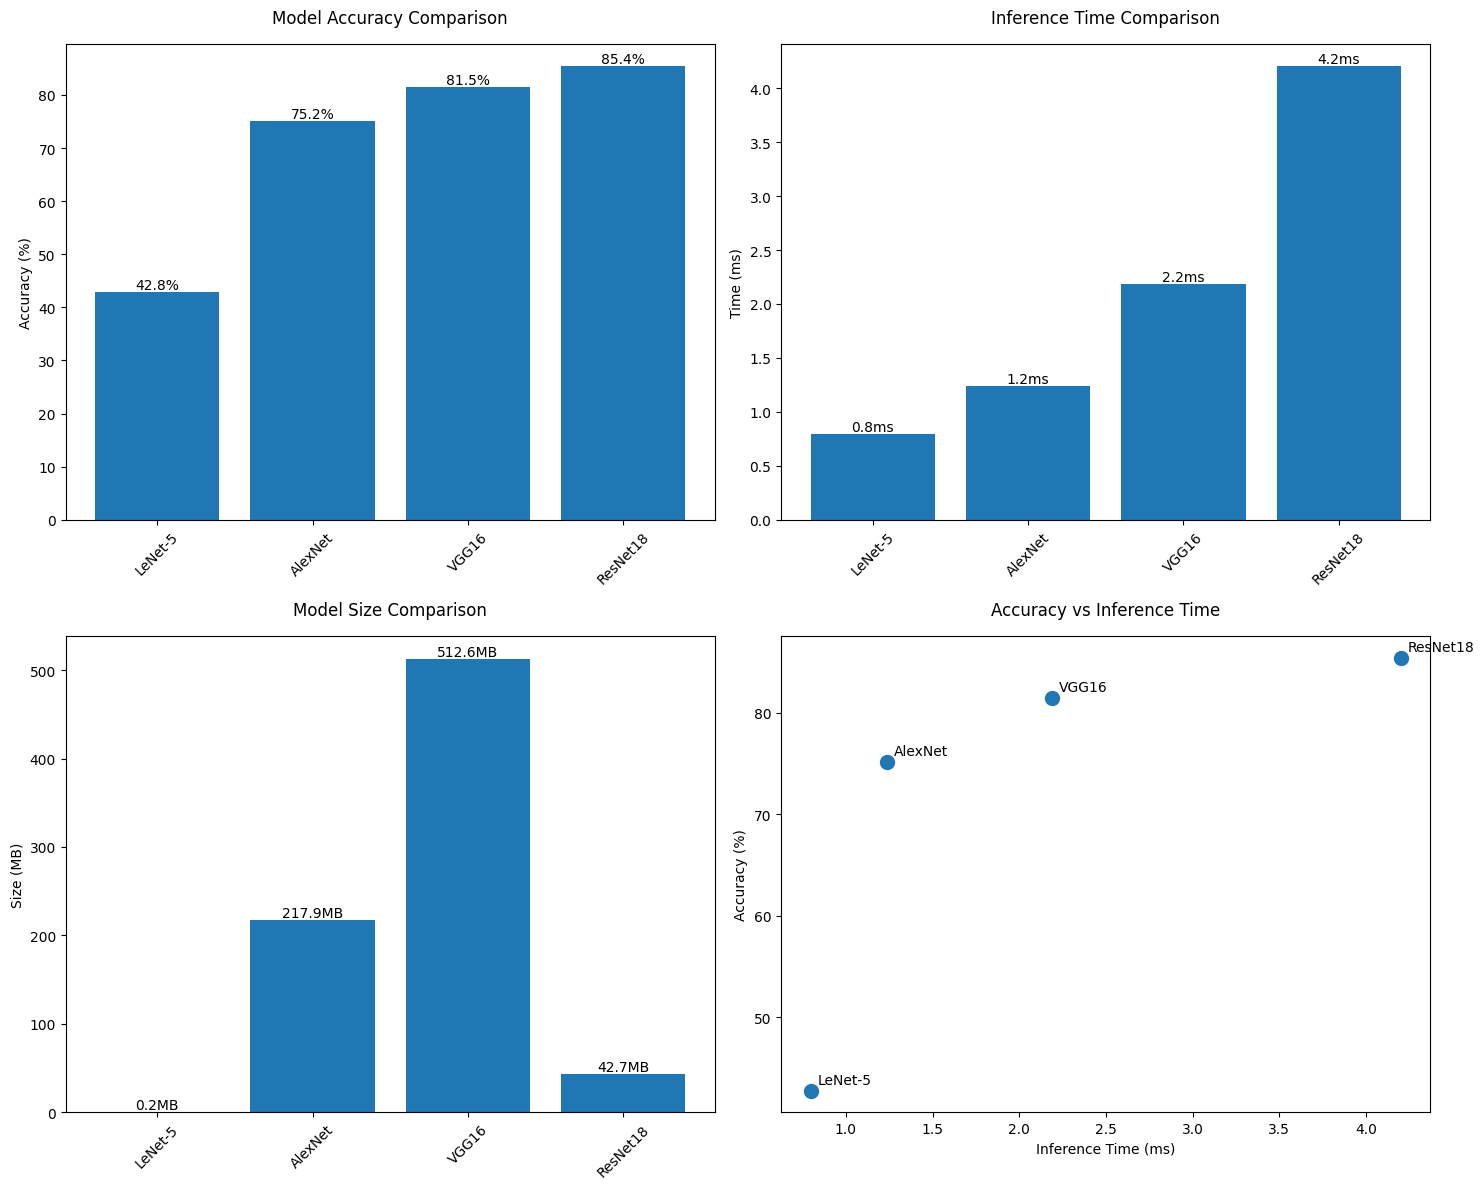

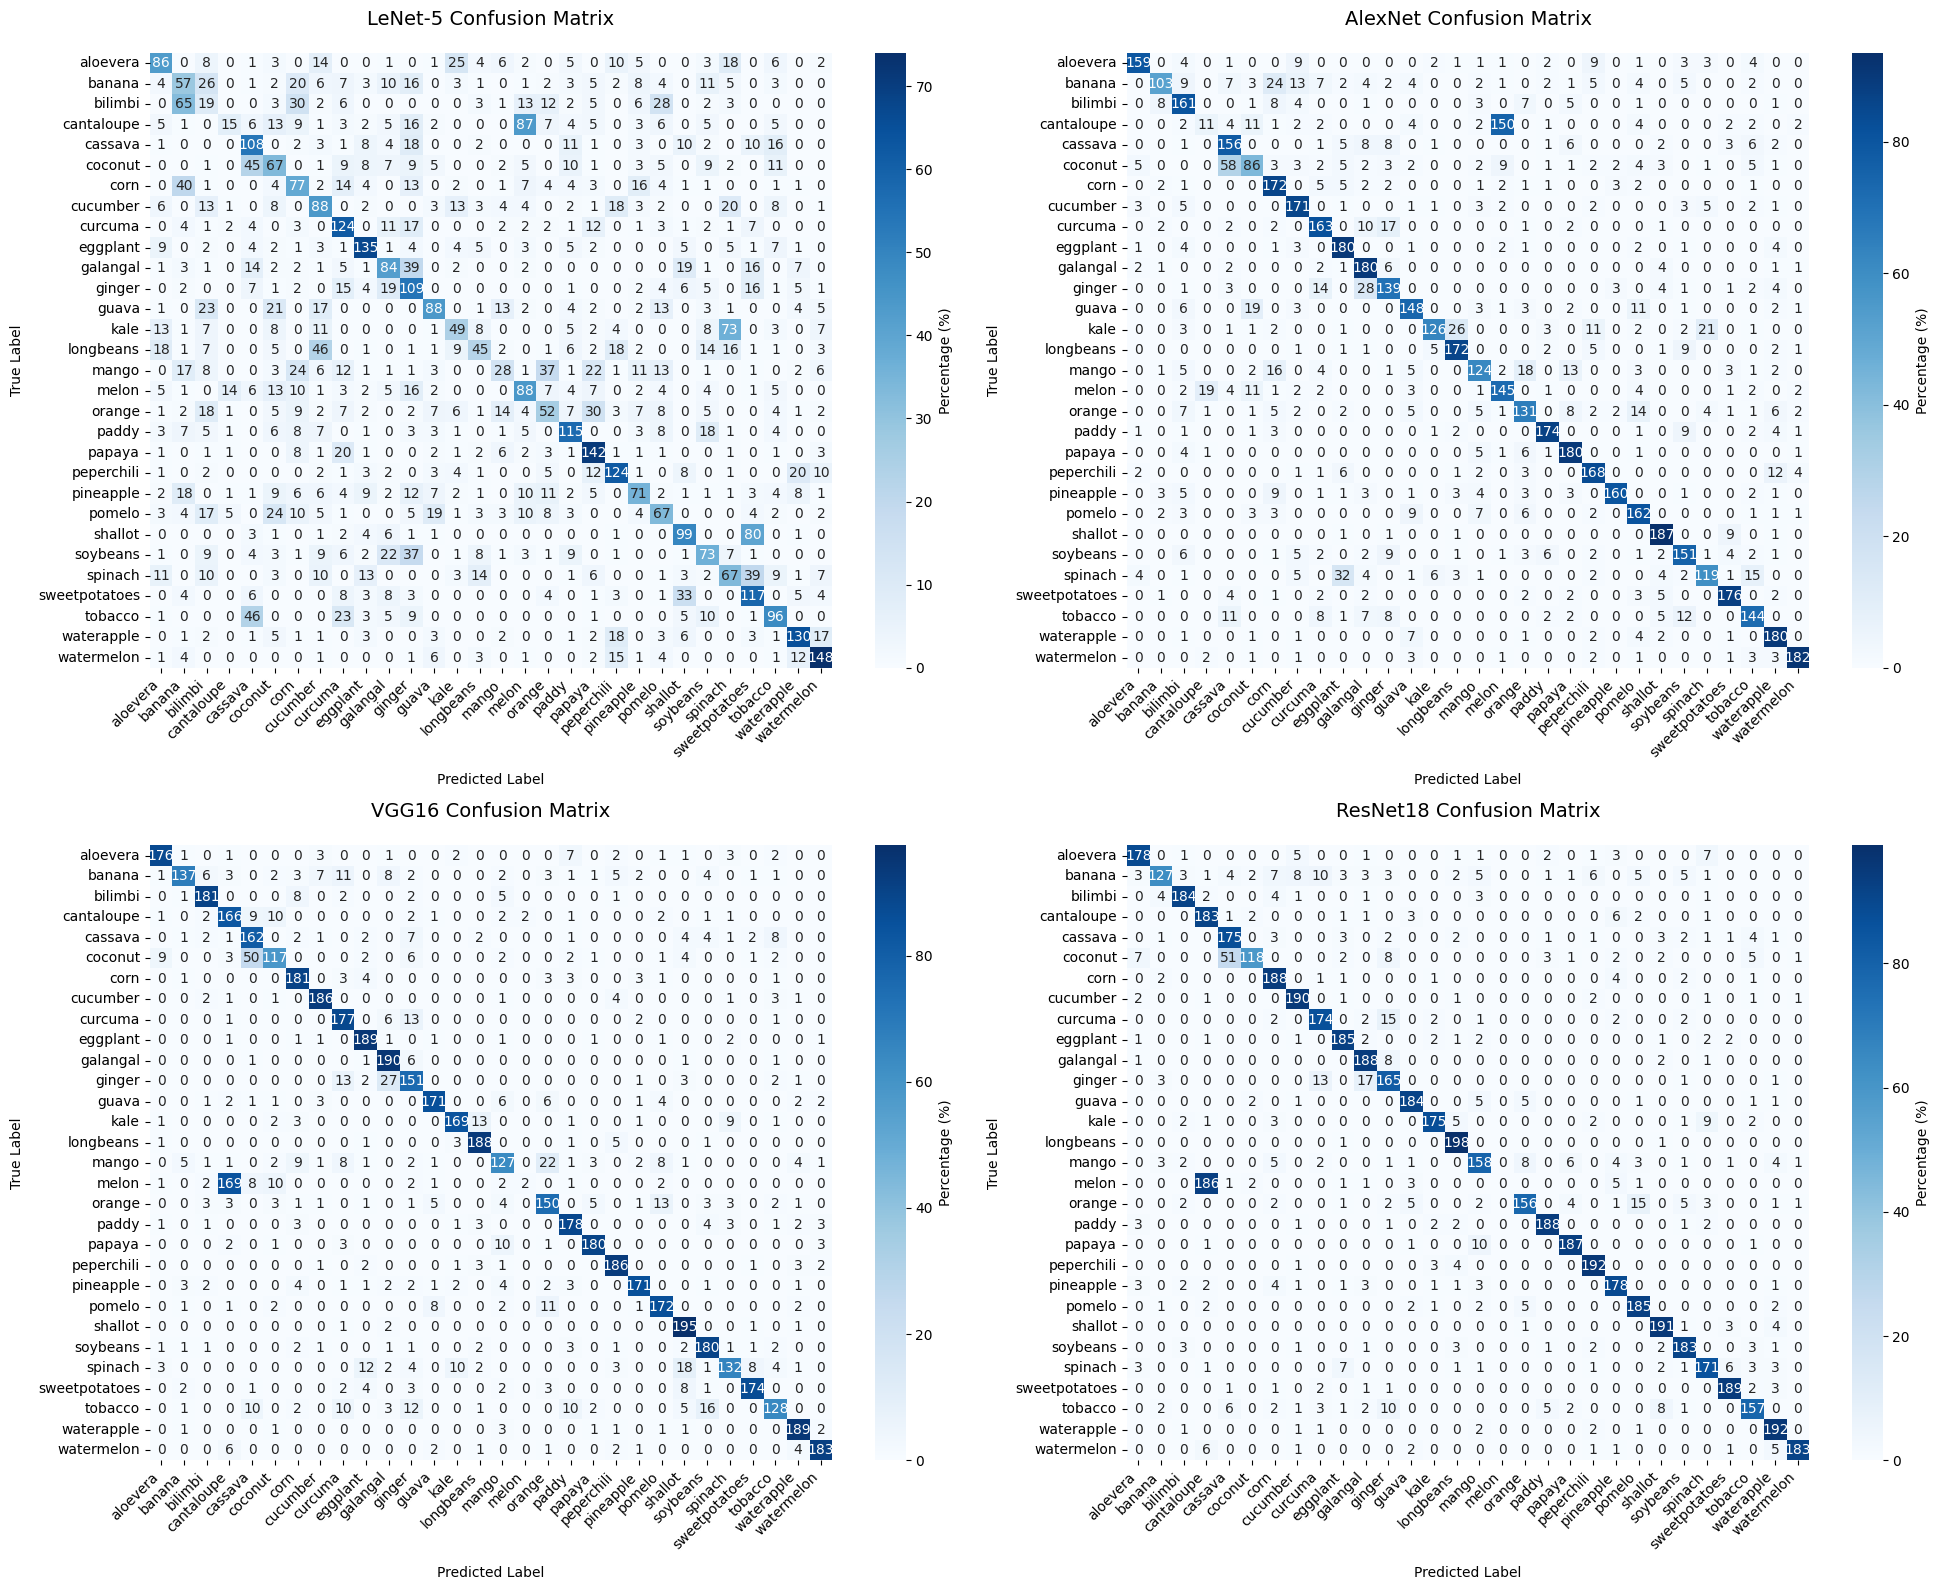

In [ ]:
# Helper functions for model comparison
# These functions evaluate and visualize the performance differences between models
# Includes metrics for size, accuracy, and inference time
# IMPORTANT: UPDATE CHECK POINT LOCATIONS
# IMPORTANT UPDATE test_loc location
def calculate_model_size(model):
    """Calculate model size in bytes"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()  # Calculate size of model parameters
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()  # Add size of buffers
    return param_size + buffer_size

def evaluate_model(model, test_loader, device):
    """Evaluate model performance"""
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    inference_times = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            inference_times.append(time.time() - start_time)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for metrics
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_inference_time = np.mean(inference_times)

    return {
        'accuracy': accuracy,
        'inference_time': avg_inference_time,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Visualization functions for model comparison
# Creates comparative plots for accuracy, inference time, model size, and confusion matrices

def plot_comparison(results, class_names):
    if not results:
        print("No results to plot!")
        return

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Accuracy Comparison
    accuracies = [data['accuracy'] for data in results.values()]
    bar1 = axes[0, 0].bar(results.keys(), accuracies)
    axes[0, 0].set_title('Model Accuracy Comparison', fontsize=12, pad=15)
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for rect in bar1:
        height = rect.get_height()
        axes[0, 0].text(rect.get_x() + rect.get_width()/2., height,
                       f'{height:.1f}%',
                       ha='center', va='bottom')

    # 2. Inference Time Comparison
    inf_times = [data['inference_time']*1000 for data in results.values()]
    bar2 = axes[0, 1].bar(results.keys(), inf_times)
    axes[0, 1].set_title('Inference Time Comparison', fontsize=12, pad=15)
    axes[0, 1].set_ylabel('Time (ms)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for rect in bar2:
        height = rect.get_height()
        axes[0, 1].text(rect.get_x() + rect.get_width()/2., height,
                       f'{height:.1f}ms',
                       ha='center', va='bottom')

    # 3. Model Size Comparison
    sizes = [data['model_size']/1024/1024 for data in results.values()]
    bar3 = axes[1, 0].bar(results.keys(), sizes)
    axes[1, 0].set_title('Model Size Comparison', fontsize=12, pad=15)
    axes[1, 0].set_ylabel('Size (MB)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    # Add value labels on bars
    for rect in bar3:
        height = rect.get_height()
        axes[1, 0].text(rect.get_x() + rect.get_width()/2., height,
                       f'{height:.1f}MB',
                       ha='center', va='bottom')

    # 4. Accuracy vs Inference Time
    axes[1, 1].scatter(inf_times, accuracies, s=100)
    for i, model in enumerate(results.keys()):
        axes[1, 1].annotate(model, (inf_times[i], accuracies[i]),
                           xytext=(5, 5), textcoords='offset points')
    axes[1, 1].set_title('Accuracy vs Inference Time', fontsize=12, pad=15)
    axes[1, 1].set_xlabel('Inference Time (ms)')
    axes[1, 1].set_ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, class_names):
    """Plot confusion matrices with improved readability"""
    n_models = len(results)

    # Calculate the number of rows needed (2 plots per row)
    n_rows = (n_models + 1) // 2

    # Create a figure with larger size
    fig, axes = plt.subplots(n_rows, 2, figsize=(20, 8 * n_rows))
    if n_models == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    # Custom colormap with better contrast
    colors = plt.cm.Blues(np.linspace(0, 1, 128))
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors) # Using mcolors instead of plt.cm


    for idx, (name, data) in enumerate(results.items()):
        ax = axes[idx]
        cm = confusion_matrix(data['true_labels'], data['predictions'])

        # Calculate percentages
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Plot the confusion matrix
        sns.heatmap(cm_percentage, annot=cm, fmt='d', ax=ax, cmap=custom_cmap,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Percentage (%)'})

        # Improve labels and title
        ax.set_title(f'{name} Confusion Matrix', pad=20, fontsize=14)
        ax.set_xlabel('Predicted Label', labelpad=10)
        ax.set_ylabel('True Label', labelpad=10)

        # Rotate tick labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Hide empty subplots if any
    for i in range(len(results), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


# Main function to compare all models
# Loads and evaluates each model using the same test dataset
# Generates comprehensive performance comparisons
def compare_all_models(test_data_path, num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    # Define configuration for each model including transforms and checkpoints
    # IMPORTANT: UPDATE CHECK POINT LOCATIONS
    model_configs = {
        'LeNet-5': {
            'transform': transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'model': LeNet5(num_classes=num_classes),
            'checkpoint': '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_lenet5.pth'
        },
        'AlexNet': {
            'transform': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'model': AlexNet(num_classes=num_classes),
            'checkpoint': '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_alexnet.pth'
        },
        'VGG16': {
            'transform': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'model': VGG16(num_classes=num_classes),
            'checkpoint': '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_vgg16.pth'
        },
        'ResNet18': {
            'transform': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'model': ResNet18(num_classes=num_classes),
            'checkpoint': '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_resnet18.pth'
        }
    }
    # Evaluate each mode
    for name, config in model_configs.items():
        print(f"\nEvaluating {name}...")
        try:
            # Load dataset with correct transform
            test_dataset = ImageFolder(test_data_path, transform=config['transform'])
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                                   num_workers=2, pin_memory=True)

            # Load model and checkpoint
            model = config['model']
            checkpoint = torch.load(config['checkpoint'])
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)

            # Evaluate model
            eval_results = evaluate_model(model, test_loader, device)
            model_size = calculate_model_size(model)

            results[name] = {
                'accuracy': eval_results['accuracy'],
                'inference_time': eval_results['inference_time'],
                'model_size': model_size,
                'predictions': eval_results['predictions'],
                'true_labels': eval_results['true_labels']
            }

            print(f"Accuracy: {eval_results['accuracy']:.2f}%")
            print(f"Avg Inference Time: {eval_results['inference_time']*1000:.2f}ms")
            print(f"Model Size: {model_size/1024/1024:.2f}MB")

        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue

    # Plot results
    plot_comparison(results, test_dataset.classes)
    plot_confusion_matrices(results, test_dataset.classes)
    return results

if __name__ == '__main__':
    # Adjust these paths and parameters
    # IMPORTANT UPDATE test_loc location
    test_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test'
    num_class = 30  # Adjust to match your dataset

    results = compare_all_models(test_loc, num_class)